# Introduction

Dear viewers, welcome! <br>
We are **Ben Arviv** and **Daniel Dubinskey**, computer science students from the **Open University of Israel**, leaning towards the fields of *Data Science* and *Machine Learning*. <br>
In the *Data Science Workshop* (20936) we learned many tools and techniques for data analysis and machine learning, and for our final project we chose to focus on the field of *Computer Vision* and *Deep Learning*. As a result, we decided to perform a data science project on a dataset we found on Kaggle, which is called **Brain Tumor Detection**.

The main goal of the project is to contribute to the early detection and diagnosis of brain tumors, which aims to provide valuable support to medical professionals in creating effective treatment plans. The dataset consists of brain scans and has a diverse range of brain tumor images that are annotated to highlight the tumor regions.

## The Problem

Brain tumor detection presents multifaceted challenges stemming from the complexity and heterogeneity of brain tumors, coupled with the limitations of current diagnostic techniques. Early detection is hindered by the nonspecific nature of symptoms in the initial stages, often leading to delayed diagnosis until tumors have progressed. <br>
Imaging modalities like MRI and CT scans, while essential, require expert interpretation and may miss subtle or small tumors, especially given the intricate anatomy of the brain. Furthermore, invasive biopsy procedures for definitive diagnosis pose risks and are not always feasible or desirable. Tumor heterogeneity exacerbates the difficulty in developing universal detection methods, and the overlap of tumor tissue with normal brain structures complicates interpretation.

Access to advanced imaging and diagnostic procedures, along with the high cost, further exacerbates disparities in healthcare access. Moreover, the need for large, diverse datasets for training AI algorithms adds another layer of complexity. Addressing these challenges necessitates collaborative efforts across disciplines to innovate non-invasive detection methods, improve imaging technology, and harness AI for more accurate and accessible brain tumor diagnosis, ultimately improving patient outcomes.

In this computer vision project, we aim to develop a brain tumor detection system leveraging a dataset comprising brain scans as input images and corresponding labels denoting the coordinates of brain tumors, where present. By harnessing advanced image processing and deep learning techniques, our objective is to accurately identify and localize brain tumors within medical imaging data. The dataset serves as a critical resource for training and evaluating our model, enabling it to learn complex patterns and features indicative of tumor presence. Through precise localization of tumors within brain scans, our system can assist healthcare professionals in early diagnosis, treatment planning, and monitoring of patients with neurological conditions. By automating the detection process, we aim to enhance efficiency, reduce human error, and ultimately improve patient outcomes in the diagnosis and management of brain tumors.

# Exploratory Data Analysis (EDA)

In order to understand the dataset and the problem we are dealing with, we will perform an exploratory data analysis (EDA) to get a sense of the data and its characteristics. This process includes examining the distribution of the data, identifying patterns and trends, applying dimensionality reduction and clustering techniques, and visualizing the data to gain insights. EDA is a crucial step in the data science process, as it helps us understand the data, identify potential issues, and inform subsequent steps in the analysis and modeling process.

In [ ]:
#remove comman if ultralytics is uninstalled
#!pip install ultralytics 

In [36]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import random
from ultralytics import YOLO

In [2]:
# Set the paths to the dataset
TRAIN_IMAGE_PATH = "train/images"
VALID_IMAGE_PATH = "valid/images"
TEST_IMAGE_PATH = "test/images"

TRAIN_LABEL_PATH = "train/labels"
VALID_LABEL_PATH = "valid/labels"
TEST_LABEL_PATH = "test/labels"

Let's see what our files look like.

In [3]:
os.listdir(TRAIN_IMAGE_PATH)[:5], os.listdir(TRAIN_LABEL_PATH)[:5]

(['volume_100_slice_100_jpg.rf.ac33e0ac3a1eebeb5e262e8a6f7de5d9.jpg',
  'volume_100_slice_101_jpg.rf.1984ae9f91c255104509b3da84cf1be6.jpg',
  'volume_100_slice_107_jpg.rf.db31be1f34abd48ca231dc24f59bd81c.jpg',
  'volume_100_slice_109_jpg.rf.77e7e40278b0f20bf3237a6da62cf6ba.jpg',
  'volume_100_slice_110_jpg.rf.0d6e7f8324e5cf7d43bfef073cae18f8.jpg'],
 ['volume_100_slice_100_jpg.rf.ac33e0ac3a1eebeb5e262e8a6f7de5d9.txt',
  'volume_100_slice_101_jpg.rf.1984ae9f91c255104509b3da84cf1be6.txt',
  'volume_100_slice_107_jpg.rf.db31be1f34abd48ca231dc24f59bd81c.txt',
  'volume_100_slice_109_jpg.rf.77e7e40278b0f20bf3237a6da62cf6ba.txt',
  'volume_100_slice_110_jpg.rf.0d6e7f8324e5cf7d43bfef073cae18f8.txt'])

It appears that the images are in `jpg` format, and the labels are in `txt` format. We will start by loading the data and examining the contents of the dataset.

In [4]:
file_paths = [os.path.join(TRAIN_LABEL_PATH, file) for file in os.listdir(TRAIN_LABEL_PATH)[:5]]

files = []
for file_path in file_paths:
    with open(file_path, 'r') as file:
        files.append(file.read())

files


['1 0.6151079136690647 0.24242424242424243 0.39568345323741005 0.3484848484848485',
 '1 0.6223021582733813 0.24242424242424243 0.381294964028777 0.3484848484848485',
 '1 0.6510791366906474 0.20454545454545456 0.23741007194244604 0.24242424242424243',
 '1 0.7122302158273381 0.26515151515151514 0.07194244604316546 0.10606060606060606',
 '1 0.7086330935251799 0.2537878787878788 0.03597122302158273 0.06818181818181818']

Each label file contains zero or more rows, each row contains an index number and the coordinates of the tumor in the image. The coordinates are in the format $(x, y, width, height)$, where $(x, y)$ is the center of the bounding box, and $width$ and $height$ are the dimensions of the bounding box. We will use this information to visualize the bounding boxes on the images and gain insights into the distribution and characteristics of the tumors.

Next, we have to check that the data is consistent, i.e., that each image has a corresponding label file and that there are no duplicate images or labels.

In [5]:
def has_label(image_name, label_path):
    return os.path.exists(os.path.join(label_path, image_name))

def check_for_duplicates(files):
    seen = set()
    dups = set()
    
    for file in files:
        if file in seen:
            dups.add(file)
        seen.add(file)
    
    return len(dups)

def data_check(path):
    counter = 0
    dups = 0
    label_path = path.replace('images', 'labels')
    images = os.listdir(path)
    labels = os.listdir(label_path)
    
    print(f'Checking: {path}')
    
    # Checks for duplicates in the dataset
    dups = check_for_duplicates(images)
    print(f'Number of duplicate images: {dups}')
    
    dups = check_for_duplicates(labels)
    print(f'Number of duplicate labels: {dups}')
    
    # Counts images without labels
    for image_name in images:
        image_name = image_name.replace('.jpg', '.txt')
        if not has_label(image_name, label_path):
            counter += 1
    print(f"Number of images without labels: {counter}")
    
    return counter


In [6]:
paths = [TRAIN_IMAGE_PATH, VALID_IMAGE_PATH, TEST_IMAGE_PATH]
for path in paths:
    data_check(path)
    print()

Checking: train/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0

Checking: valid/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0

Checking: test/images
Number of duplicate images: 0
Number of duplicate labels: 0
Number of images without labels: 0



We see that each image has a corresponding label file, which means that we have a one-to-one mapping between images and labels. This will allow us to associate the tumor annotations with the corresponding images and use them for training and evaluation of our model. We also verified that there are no duplicate images or labels in the dataset, ensuring that the data is clean and consistent.

Using the `cv2` library, we can read the images properly.

In [7]:
def read_images(imgs_path):
    images = []
    
    for img_name in os.listdir(imgs_path):
        img = cv2.imread(os.path.join(imgs_path, img_name))
        images.append(img)
        
    return images

In [8]:
# Load train images
train_images = read_images(TRAIN_IMAGE_PATH)

In [9]:
train_images[0].shape, train_images[0]

((132, 139, 3),
 array([[[11, 12, 10],
         [11, 12, 10],
         [11, 12, 10],
         ...,
         [11, 12, 10],
         [11, 12, 10],
         [11, 12, 10]],
 
        [[11, 12, 10],
         [11, 12, 10],
         [11, 12, 10],
         ...,
         [11, 12, 10],
         [11, 12, 10],
         [11, 12, 10]],
 
        [[11, 12, 10],
         [11, 12, 10],
         [11, 12, 10],
         ...,
         [11, 12, 10],
         [11, 12, 10],
         [11, 12, 10]],
 
        ...,
 
        [[11, 12, 10],
         [11, 12, 10],
         [11, 12, 10],
         ...,
         [11, 12, 10],
         [11, 12, 10],
         [11, 12, 10]],
 
        [[11, 12, 10],
         [11, 12, 10],
         [11, 12, 10],
         ...,
         [11, 12, 10],
         [11, 12, 10],
         [11, 12, 10]],
 
        [[11, 12, 10],
         [11, 12, 10],
         [11, 12, 10],
         ...,
         [11, 12, 10],
         [11, 12, 10],
         [11, 12, 10]]], dtype=uint8))

Each image is a 3D array, where the first two dimensions represent the pixel values of the image, and the third dimension represents the color channels (RGB). 

We will create a *DataFrame* object to store the labels, with each row representing an image and its corresponding tumor coordinates, sizes and average size (if present). This will allow us to easily access and manipulate the labels, and merge them with the image data for visualization and analysis.

In [10]:
def read_labels(lbls_path, imgs_path, images):
    labels = pd.DataFrame(columns=['number of tumors', 'list of tumors', 'sizes of tumors'])

    for i, file_path in enumerate(os.listdir(imgs_path)):
        file_path = file_path.replace('.jpg', '.txt')
        file_path = os.path.join(lbls_path, file_path)
        with open(file_path, 'r') as file:
            lines = file.readlines()
            boxes_list = []
            sizes_list = []
            if len(lines) == 0:
                labels.loc[i] = [0, [], []]
                continue
            
            img_width, img_height = images[i].shape[:2]
            for line in lines:
                line = line.strip().split()
                
                _, x, y, width, height = list(map(float, line))
                xmin = (x - width / 2) * img_width
                ymin = (y - height / 2) * img_height
                xmax = (x + width / 2) * img_width
                ymax = (y + height / 2) * img_height
                
                size = (width / img_width) * (height / img_height)
                sizes_list.append([size])
                boxes_list.append([xmin, ymin, xmax, ymax])
            
            labels.loc[i] = [len(boxes_list), boxes_list, sizes_list]
            
    labels['average tumor size'] = labels['sizes of tumors'].apply(lambda x: np.mean(x) if len(x) > 0 else 0)
    
    return labels

In [11]:
# Load train labels
train_labels = read_labels(TRAIN_LABEL_PATH, TRAIN_IMAGE_PATH, train_images)

In [12]:
train_labels.head()

,number of tumors,list of tumors,sizes of tumors,average tumor size
0,1,"[[55.07913669064747, 9.477272727272727, 107.30...",[[7.515243527872274e-06]],7.515244e-06
1,1,"[[56.97841726618705, 9.477272727272727, 107.30...",[[7.241961945040556e-06]],7.241962e-06
2,1,"[[70.27338129496401, 11.583333333333334, 101.6...",[[3.1367972985901663e-06]],3.136797e-06
3,1,"[[89.26618705035972, 29.48484848484848, 98.762...",[[4.1586327822218113e-07]],4.158633e-07
4,1,"[[91.16546762589928, 30.53787878787879, 95.913...",[[1.3367033942855822e-07]],1.336703e-07


Now that everything is set, we can start analyzing the data. First, we will visualize the images and their corresponding tumor annotations.

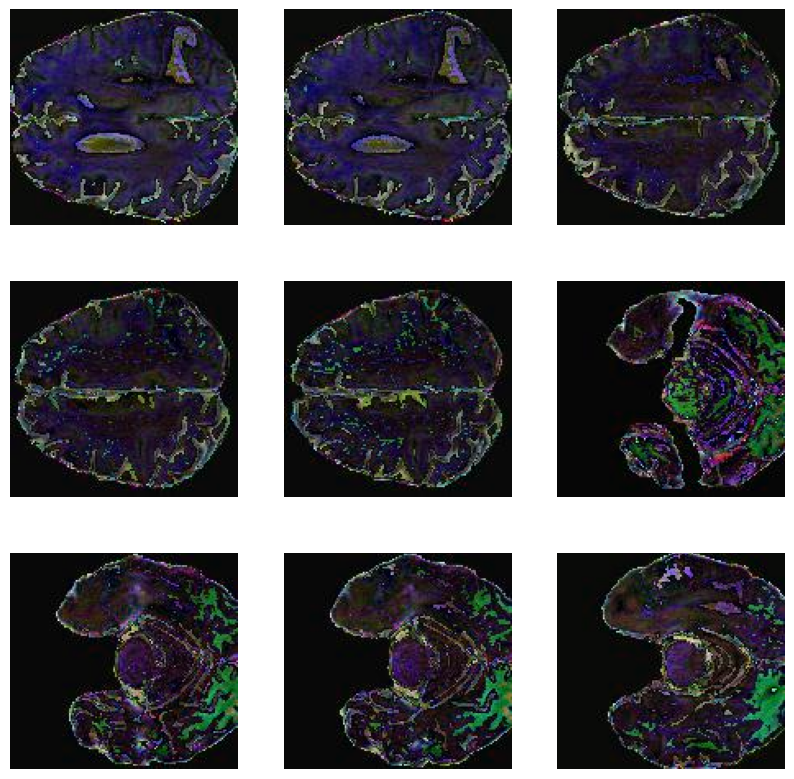

In [13]:
# Plot images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_images[i])
    ax.axis('off')

All of the images are brain scans, in what appears to be different axial depths of the brain, according to the actual brain scan and color of the image. All of the images are of the same size, and they may or may not contain tumors. 

The resulting images should be displayed with the bounding boxes around the tumors, if present, as in the example below:

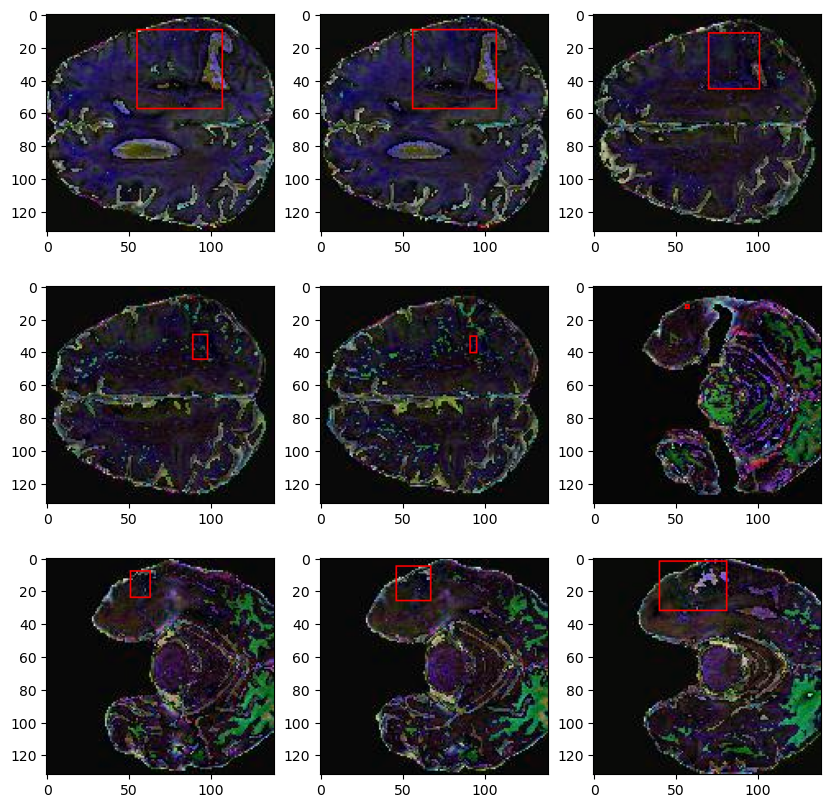

In [14]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flatten()):
    img = train_images[i]
    box = train_labels.loc[i, 'list of tumors'][0]
    xmin, ymin, xmax, ymax = list(map(int, box))
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)
    ax.imshow(img)

Now for some statistics about the dataset:

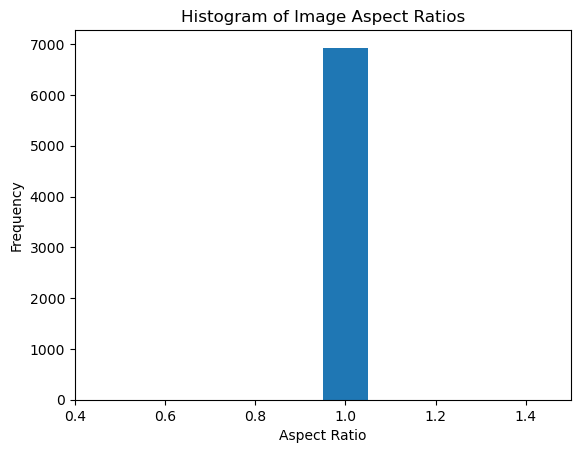

In [15]:
# Calculate the aspect ratio of each image
img_width, img_height = train_images[i].shape[:2]
aspect_ratios = [img_width / img_height for img_width, img_height in [img.shape[:2] for img in train_images]]

# Plot the histogram
plt.hist(aspect_ratios, bins=10)
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of Image Aspect Ratios')
plt.show()


All of the images are of the same aspect ratio and dimensions, which is a good thing, as it will allow us to train a model on the images without having to worry about resizing them. Since the images' dimensions are $132\times 139\times 3$, we will have $51,708$ features for each image (quite a lot).

We now take a closer look at the color distribution of the images. We will plot the histograms of the pixel values for each color channel (R, G, B) to visualize the distribution of colors in the images.

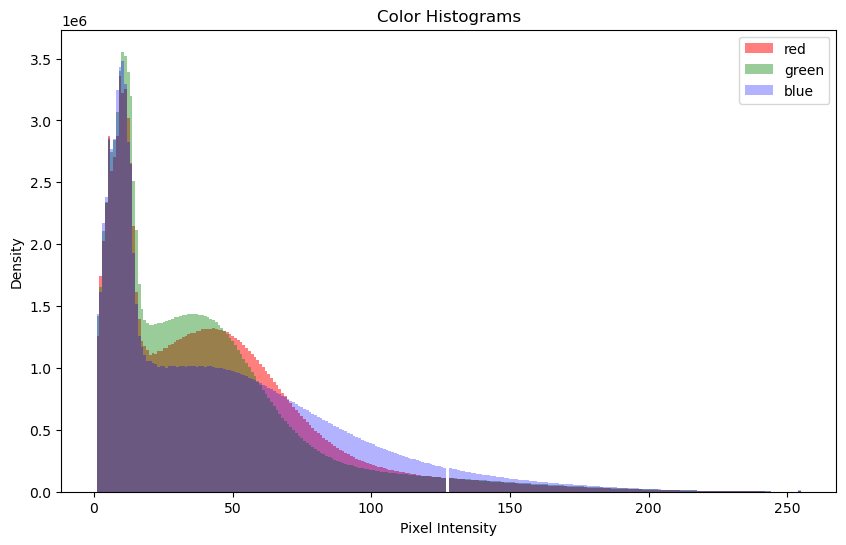

In [16]:
# Flatten the images and separate color channels
red = np.array([image[:, :, 0].flatten() for image in train_images]).flatten()
green = np.array([image[:, :, 1].flatten() for image in train_images]).flatten()
blue = np.array([image[:, :, 2].flatten() for image in train_images]).flatten()

red = red[red != 0]
green = green[green != 0]
blue = blue[blue != 0]

plt.figure(figsize=(10, 6))
plt.hist(red, label='red', bins=256, density=False, color='red', alpha=0.5)
plt.hist(green, label='green', bins=256, density=False, color='green', alpha=0.4)
plt.hist(blue, label='blue', bins=256, density=False, color='blue', alpha=0.3)

plt.title('Color Histograms')
plt.xlabel('Pixel Intensity')
plt.ylabel('Density')
plt.legend()
plt.show()

We notice that the images are mostly dark, with two peaks in the histograms, one around 0 and the other around 50. This indicates that the images have a low dynamic range, with most pixel values concentrated around the lower end of the scale. This could be due to the nature of the brain scans and the imaging modality used to capture them. The histograms show that the images have a relatively uniform distribution of pixel values across the color channels, with no significant outliers or anomalies.

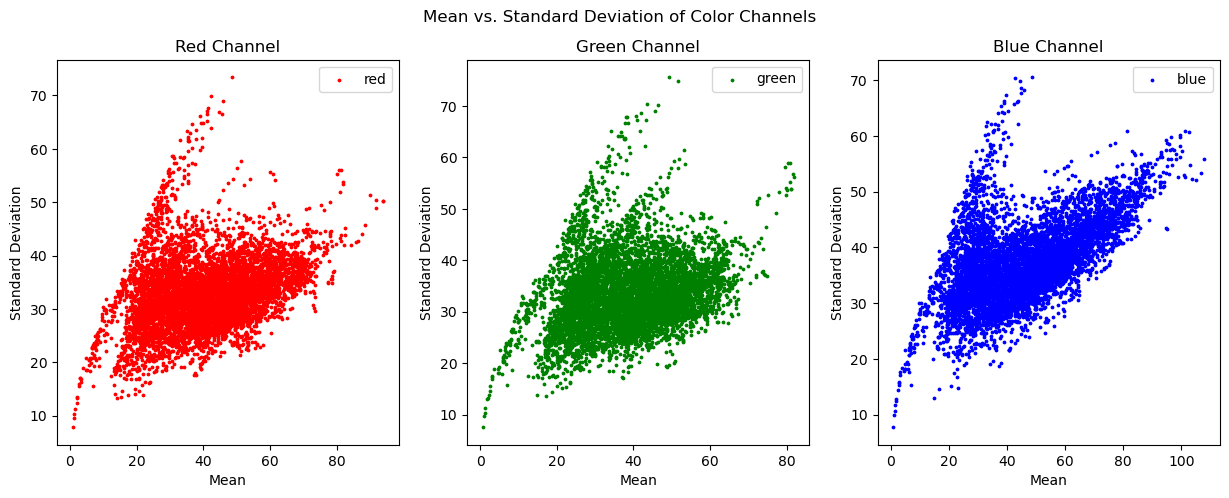

In [17]:
color_df = pd.DataFrame(columns=['red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std'])
channels = ['red', 'green', 'blue']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for channel in channels:
    color_df[f'{channel}_mean'] = [np.mean(img[:, :, channels.index(channel)]) for img in train_images]
    color_df[f'{channel}_std'] = [np.std(img[:, :, channels.index(channel)]) for img in train_images]
    ax = axes[channels.index(channel)]
    ax.scatter(color_df[f'{channel}_mean'], color_df[f'{channel}_std'], label=channel, c='r' if channel == 'red' else 'g' if channel == 'green' else 'b', s=3)
    ax.set_xlabel('Mean')
    ax.set_ylabel('Standard Deviation')
    ax.set_title(f'{channel.capitalize()} Channel')
    ax.legend()
    
fig.suptitle('Mean vs. Standard Deviation of Color Channels')
plt.show()


This plot supports our previous observation that the images are mostly dark, with pixel values concentrated around the lower end of the scale, and the variability in pixel values across the color channels is relatively low. In addition, we see that the pixel values are forming one big cluster, which indicates that the images are not very diverse in terms of color distribution. This means that the color information may not be as informative for distinguishing between tumor and non-tumor regions in the images, and other features such as texture and shape may play a more significant role in tumor detection.

<Axes: xlabel='number of tumors', ylabel='count'>

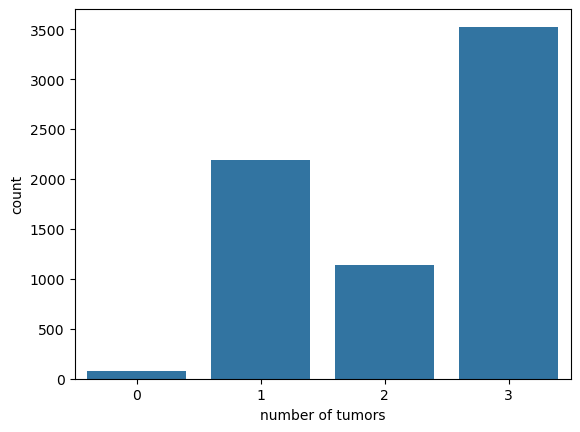

In [18]:
sns.countplot(x='number of tumors', data=train_labels)

As we can see, the dataset contains images with varying numbers of tumors, ranging from zero to three tumors per image, in the training set. The vast majority of images contain at least one tumor, but there is a small amount of images with no tumors. It appears that the distribution of tumors is skewed, with a higher proportion of images containing tumors compared to those without tumors. It may lead to a class imbalance problem, which we will need to address during the modeling phase.

Text(0.5, 1.0, 'Average Tumor Size Distribution')

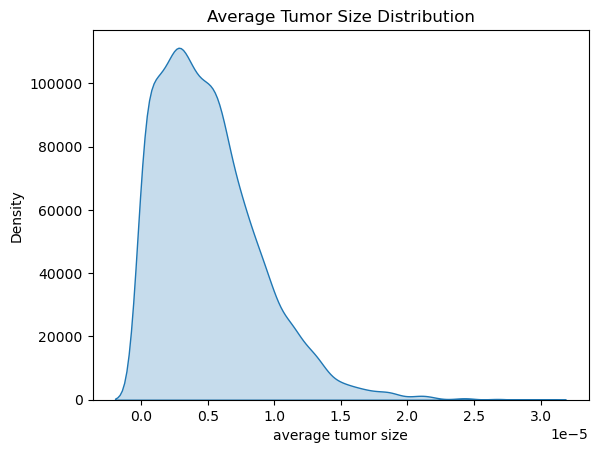

In [19]:
sns.kdeplot(train_labels['average tumor size'], fill=True)
plt.title('Average Tumor Size Distribution')

Most of the tumors are of a similar size, but there are some with larger sizes, and the plot is quite narrow, which means that the sizes of the tumors are quite similar. We can see that the plot is skewed to the right, which means that most of the tumors are small, but there are some larger tumors as well. No noticable outliers are present in the data. Let's check if it has any correlation with the number of tumors in the image.

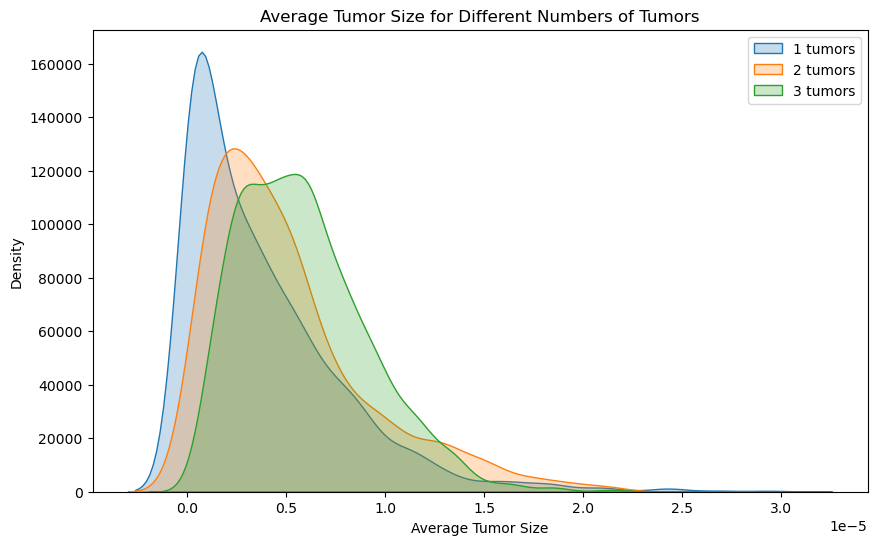

In [20]:
plt.figure(figsize=(10, 6))

# Create a separate KDE plot for each number of tumors from 1 to 3
for i in range(1, 4):
    subset = train_labels[train_labels['number of tumors'] == i]['average tumor size']
    sns.kdeplot(subset, label=f'{i} tumors', fill=True)

plt.title('Average Tumor Size for Different Numbers of Tumors')
plt.xlabel('Average Tumor Size')
plt.ylabel('Density')
plt.legend()
plt.show()

It may look like larger tumors are more common when there are multiple tumors in the image, with most of the tumor sizes being in the higher range of the scale, with respect to the average tumor size for scans with one tumor. This is not a deterministic conclusion, but it is a trend that we can see in the data.

The following plot shows the distribution of the aspect ratios of the tumors in the dataset. The aspect ratio is calculated as the ratio of the width to the height of the bounding box. It provides insights into the shape and orientation of the tumors, which can be useful for understanding the characteristics of the tumors and designing appropriate detection algorithms. In our dataset, the aspect ratios of the tumors are relatively identical, with most of the tumors having an aspect ratio that lies between 1 and 2. This indicates that the tumors are generally elongated or oval-shaped, rather than circular or irregular.

In [21]:
def get_dimensions(df):
    width = df['xmax'] - df['xmin']
    height = df['ymax'] - df['ymin']
    aspect_ratios = width / height
    
    return width, height, aspect_ratios

Text(0.5, 1.0, 'Tumor Aspect Ratio Distribution')

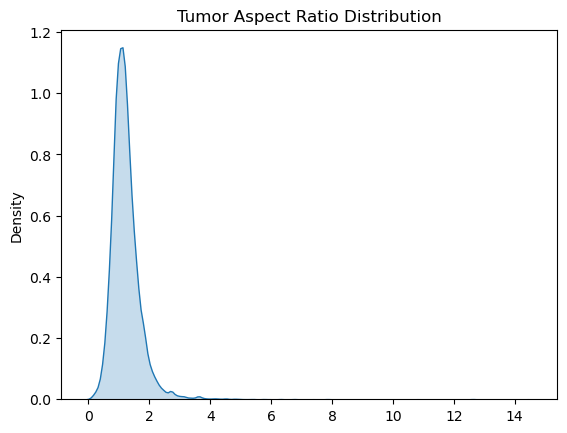

In [22]:
tumors = train_labels['list of tumors']
tumors = [tumor for tumor_list in tumors for tumor in tumor_list]
tumors_df = pd.DataFrame(tumors, columns=['xmin', 'ymin', 'xmax', 'ymax'])

width, height, aspect_ratios = get_dimensions(tumors_df)

sns.kdeplot(aspect_ratios, fill=True)
plt.title('Tumor Aspect Ratio Distribution')


Is there any correlation between the number of tumors and the aspect ratio of the tumors?

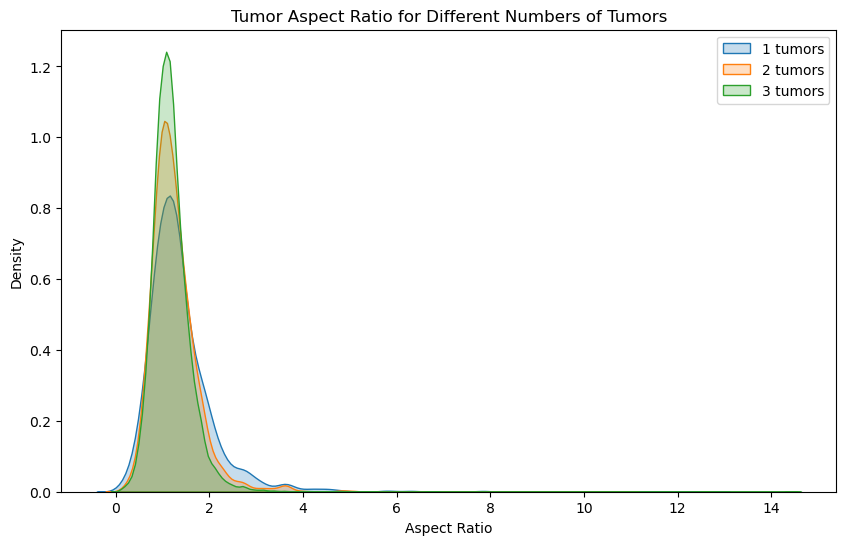

In [23]:
plt.figure(figsize=(10, 6))

# Create a separate KDE plot for each number of tumors from 1 to 3
for i in range(1, 4):
    tumors = train_labels[train_labels['number of tumors'] == i]['list of tumors']
    tumors = [tumor for tumor_list in tumors for tumor in tumor_list]
    tumors_df = pd.DataFrame(tumors, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    
    width, height, aspect_ratios = get_dimensions(tumors_df)
    
    sns.kdeplot(aspect_ratios, label=f'{i} tumors', fill=True)
    
plt.title('Tumor Aspect Ratio for Different Numbers of Tumors')
plt.xlabel('Aspect Ratio')
plt.ylabel('Density')
plt.legend()
plt.show()

Well, no. The aspect ratio of the tumors is relatively consistent across images with different numbers of tumors, which suggests that the shape and orientation of the tumors are similar regardless of the number of tumors in the image. This is an interesting observation, as it indicates that the tumors have a consistent shape and orientation, regardless of their size or number in the image.

The following heatmap shows the location of the tumors in the brain scans, which provides insights into the distribution and spatial characteristics of the tumors. The heatmap reveals that the tumors are predominantly located in the central region of the brain scans, but for some reason, they are split into two 'kind-of' clusters - in the middle left and middle right of the brain scans, with a few outliers in the bottom, between the two clusters. This distribution may be due to the nature of the brain anatomy and the prevalence of tumors in specific regions of the brain. 

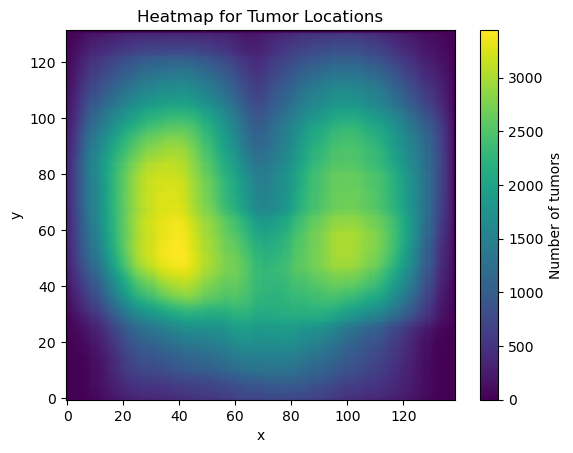

In [24]:
tumors = train_labels['list of tumors']
tumors = [tumor for tumor_list in tumors for tumor in tumor_list]
tumors_df = pd.DataFrame(tumors, columns=['xmin', 'ymin', 'xmax', 'ymax'])

image_width = train_images[0].shape[1]
image_height = train_images[0].shape[0]

heatmap = np.zeros((image_height, image_width))

for _, row in tumors_df.iterrows():
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
    for x in range(int(round(xmin)), int(round(xmax))):
        for y in range(int(round(ymin)), int(round(ymax))):
            heatmap[x, y] += 1

plt.imshow(heatmap, origin='lower')
plt.colorbar(label='Number of tumors')
plt.title('Heatmap for Tumor Locations')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

As preatty as those plots are, we will need some more informative statistics about the dataset. We will move on to show some more sophisticated features of the dataset.

# Data training 


####  create yaml file change path according to your own pc


In [53]:
%%writefile tumor_v8.yaml
path: 'C:/Users/danid/WorkShop/Brain-Tumor-Detection' 
train: 'train/images'
val: 'valid/images'

#class names
names:
    0: '0'
    1: '1'
    2: '2'

Overwriting tumor_v8.yaml


In [54]:
EPOCHS = 5
BATCH = 8
IMG_SIZE = 240

In [55]:
model = YOLO('yolov8n.pt')

In [56]:
results = model.train(
    data = 'tumor_v8.yaml',
    imgsz = IMG_SIZE,
    epochs = EPOCHS,
    batch = BATCH,
    name = 'output'
)

Ultralytics YOLOv8.2.2  Python-3.10.13 torch-2.2.2 CPU (12th Gen Intel Core(TM) i7-12700KF)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=tumor_v8.yaml, epochs=5, time=None, patience=100, batch=8, imgsz=240, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=output, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

train: Scanning C:\Users\danid\WorkShop\Brain-Tumor-Detection\train\labels.cache... 6930 images, 79 backgrounds, 0 corrupt: 100%|██████████| 6930/6930 [00:00<?, ?it/s]
val: Scanning C:\Users\danid\WorkShop\Brain-Tumor-Detection\valid\labels.cache... 1980 images, 17 backgrounds, 0 corrupt: 100%|██████████| 1980/1980 [00:00<?, ?it/s]

Plotting labels to runs\detect\output\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 256 train, 256 val
Using 0 dataloader workers
Logging results to runs\detect\output
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.885      2.392      1.647          6        256: 100%|██████████| 867/867 [03:01<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:19<00:00,  6.30it/s]


                   all       1980       4380      0.383      0.403      0.348      0.137

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.792        1.9      1.585          5        256: 100%|██████████| 867/867 [03:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:23<00:00,  5.38it/s]


                   all       1980       4380      0.501      0.448      0.421      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.731       1.76      1.559          7        256: 100%|██████████| 867/867 [03:22<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:23<00:00,  5.28it/s]


                   all       1980       4380       0.55      0.495      0.479      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.668      1.628      1.511          4        256: 100%|██████████| 867/867 [03:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:21<00:00,  5.79it/s]


                   all       1980       4380      0.625      0.484      0.522      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G       1.61      1.519      1.478          4        256: 100%|██████████| 867/867 [03:20<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:19<00:00,  6.23it/s]


                   all       1980       4380      0.681      0.543      0.585      0.303

5 epochs completed in 0.301 hours.
Optimizer stripped from runs\detect\output\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\output\weights\best.pt, 6.2MB

Validating runs\detect\output\weights\best.pt...
Ultralytics YOLOv8.2.2  Python-3.10.13 torch-2.2.2 CPU (12th Gen Intel Core(TM) i7-12700KF)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [00:18<00:00,  6.66it/s]


                   all       1980       4380      0.682      0.543      0.585      0.303
                     0       1980       1246      0.631       0.39      0.454      0.192
                     1       1980       1944      0.749      0.718      0.754      0.454
                     2       1980       1190      0.665      0.521      0.546      0.263
Speed: 0.1ms preprocess, 7.7ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs\detect\output


In [ ]:
!yolo task=detect mode=predict model=C:/Users/danid/WorkShop/Brain-Tumor-Detection/runs/detect/output6/weights/best.pt conf=0.25 source=C:/Users/danid/WorkShop/Brain-Tumor-Detection/test/images save=True